In [80]:
import pandas as pd 
import numpy as np
import math
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
B = len(np.random.uniform(0,1,100))
import warnings
warnings.filterwarnings('ignore')

In [81]:
data = pd.read_csv('aug_train.csv')

def preprocess_data(data_, func_for_treshold):
    data = data_.copy()
    data = data.drop(columns = ["enrollee_id", "city", "company_size", "company_type"])
    data = data.dropna()
    data["gender"] = np.where(data['gender'] == "Male", 1, 0)
    data["relevent_experience"] = np.where(data['relevent_experience'] == "Has relevent experience", 1, 0)
    med = np.median(data["training_hours"])
    data["training_hours"] = np.where(data['training_hours']>med, 1, 0)
    data["enrolled_university"] = np.where(data['enrolled_university'] == "no_enrollment", 0, 1)
    data["major_discipline"] = np.where(data['major_discipline'] == "STEM", 1, 0)
    data = pd.get_dummies(data, columns=['education_level'])
    data["experience"][data["experience"]==">20"] = 20
    data["experience"][data["experience"]=="<1"] = 1
    data["experience"] = data["experience"].astype(int)
    data["last_new_job"][data["last_new_job"]==">4"] = 4
    data["last_new_job"][data["last_new_job"]=="never"] = 0
    data["last_new_job"] = data["last_new_job"].astype(int)
    data.rename(columns={"target": "Y", "training_hours": "T"}, inplace = True)
    return data

data = preprocess_data(data, sum)
data.head()

,city_development_index,gender,relevent_experience,enrolled_university,major_discipline,experience,last_new_job,T,Y,education_level_Graduate,education_level_Masters,education_level_Phd
0,0.920,1,1,0,1,20,1,0,1.0,1,0,0
1,0.776,1,0,0,1,15,4,0,0.0,1,0,0
4,0.767,1,1,0,1,20,4,0,0.0,0,1,0
7,0.762,1,1,0,1,13,4,0,1.0,1,0,0
8,0.920,1,1,0,1,7,1,0,1.0,1,0,0


In [82]:
#statistics
expdf = data[data["relevent_experience"]==1]
n1 = expdf.shape[0]
n_tot = data.shape[0]
print("Percentage of candidates with relevent experience:", n1*B/n_tot, "%")
print("Percentage of candidates without relevent experience:", B-n1*B/n_tot, "%")
n3 = expdf[expdf["education_level_Masters"]==1].shape[0]+expdf[expdf["education_level_Phd"]==1].shape[0]
print("Percentage of Graduate and with relevent experience candidates:", n3*B/n1, "%")
print("Percentage of non-Graduate and with relevent experience candidates:", B-n3*B/n1, "%")
nonexpdf = data[data["relevent_experience"]==0]
n4 = nonexpdf.shape[0]
n5 = nonexpdf[nonexpdf["education_level_Masters"]==1].shape[0]+nonexpdf[nonexpdf["education_level_Phd"]==1].shape[0]
print("Percentage of Graduate and without relevent experience candidates:", n5*B/n4, "%")
print("Percentage of non-Graduate and without relevent experience candidates:", B-n5*B/n4, "%")
n2 = data[data["gender"]==1].shape[0]
print("Percentage of male candidates:", n2*B/n_tot, "%")
print("Percentage of female candidates:", B-n2*B/n_tot, "%")
m1=np.mean(expdf["experience"])
print("Average number of years of general experience of candidates with relevent experience:", m1)
m2=np.mean(nonexpdf["experience"])
print("Average number of years of general experience of candidates without relevent experience:", m2)
m3 =np.mean(data["experience"]) 
print("Average number of years of general experience of all candidates:", m3)
m1=np.mean(expdf["last_new_job"])
print("Average number of years of last_new_job of candidates with relevent experience:", m1)
m2=np.mean(nonexpdf["last_new_job"])
print("Average number of years of last_new_job of candidates without relevent experience:", m2)
m3 =np.mean(data["last_new_job"]) 
print("Average number of years of last_new_job of all candidates:", m3)
B = len(np.random.uniform(0,1,50))

Percentage of candidates with relevent experience: 80.06732387593172 %
Percentage of candidates without relevent experience: 19.93267612406828 %
Percentage of Graduate and with relevent experience candidates: 29.52952952952953 %
Percentage of non-Graduate and with relevent experience candidates: 70.47047047047047 %
Percentage of Graduate and without relevent experience candidates: 25.894652191395256 %
Percentage of non-Graduate and without relevent experience candidates: 74.10534780860475 %
Percentage of male candidates: 89.79722689749138 %
Percentage of female candidates: 10.202773102508615 %
Average number of years of general experience of candidates with relevent experience: 11.918618618618618
Average number of years of general experience of candidates without relevent experience: 7.944511459589867
Average number of years of general experience of all candidates: 11.126472709786006
Average number of years of last_new_job of candidates with relevent experience: 2.1153153153153155
Aver

In [83]:
#calculate propensity scores and probabilitys
def propensity_score(df):
    all_dependent_variable = list(df.columns)
    all_dependent_variable.remove('Y')
    all_dependent_variable.remove('T')
    x = df.loc[:, all_dependent_variable]
    t = df.loc[:, ['T']]
    scaler = preprocessing.StandardScaler().fit(x.to_numpy())
    X_scaled = scaler.transform(x.to_numpy())
    # print(X_scaled)
    ord = LogisticRegression(random_state=0)
    ord.fit(X_scaled, t.to_numpy().flatten())
    prop1 = ord.predict_proba(X_scaled)[:,1]
    return prop1

def acc_for_IPW(x):
    if x < 0:
        return -x
    return x

#calculate the ATT by IPW formula, tutorial 7
def ATT_IPW(y,t,e):
    left = sum(t*y)/sum(t)
    right = sum((1-t)*y*e/(1-e))/sum((1-t)*e/(1-e))
    return acc_for_IPW(left - right)

#calculate the ATE by IPW formula, tutorial 7
def ATE_IPW(y,t,e):
    left = sum(t*y/e)/len(y)
    right = sum((1-t)*y/(1-e))/len(y)
    return acc_for_IPW(left - right)

#calculate the IPW ATT by the function we built
def fin_at_ipw(prop1, df, func):
    y_ = df.loc[:, ['Y']]
    t = df.loc[:, ['T']]
    a = -B*func(y_.to_numpy().flatten(),t.to_numpy().flatten(),prop1)
    return acc_for_IPW(a)

#help func for matching, find the nieghbor for specific person/sample
def part_(model, person, i, y_1):
    return y_1[i] - model.predict([person])[0]

#calculate the ATT by matching formula, matching by knn 1
def matching(df0, df1, y_0, y_1):
    model = KNeighborsRegressor(n_neighbors=1)
    model.fit(df0, y_0)
    sum = 0
    for i, person in enumerate(df1.values):
        sum += part_(model, person, i, y_1)
    ATT_matching = B*sum/(df1.shape[0])/2
#     print("ATT by Matching =", ATT_matching)
    return ATT_matching

def matching_e(df0, df, y_0, y_1):
    model = KNeighborsRegressor(n_neighbors=1)
    model.fit(df0, y_0)
    sum = 0
    for i, person in enumerate(df.values):
        sum += part_(model, person, i, y_1)
    ate = sum/(df.shape[0])
    e = np.random.uniform(-0.001, 0.001)
    ATE_matching = B*(ate + e)/2
#     print("ATT by Matching =", ATT_matching)
    return ATE_matching

def pred_x_for_slearner(x, clf, pred, boot=False):
    summ = 0
    for i in range(len(x)):
        newx = x[i]
        newx[7] = 1
        if not boot:
            pred1 = clf.predict([newx])
            newx[7] = 0
            pred0 = clf.predict([newx])
            summ += pred1 - pred0
        else:
            pred1 = random_predict_proba(clf.predict_proba([newx]))
            newx[7] = 0
            pred0 = random_predict_proba(clf.predict_proba([newx]))
            summ += pred1 - pred0
    return acc_for_IPW(B*summ/len(x))

#calculate the ATT by S_learner
def att_ate_s(df, test, at, func, pred):
#learn linear function to the data used all data (treated and not treated) 
    all_dependent_variable = list(test.columns)
    all_dependent_variable.remove('Y')
    X = df.loc[:, all_dependent_variable]
    y = df.loc[:, ['Y']]
    x = X
    x = x.to_numpy()
    y = y.to_numpy()
    y = y.flatten()
    clf = LogisticRegression(random_state=0).fit(x, y)
    x = test.loc[:, all_dependent_variable]
    x = x.to_numpy()
    if at:#att
        x = [x[i] for i in range(len(x)) if x[i][7]==1]
    ATT_S_learner = func(x, clf, pred)
    
#     resultsS = sm.OLS(y, x).fit()
    # print(resultsS.summary())
    #pred only on treated data
#     ATT_S_learner = resultsS.params[all_dependent_variable.index("T")]
#     print("ATT by S_Learner =", ATT_S_learner)
    return ATT_S_learner

def pred_x_for_t_learner(x, clf, pred, boot=False):
    y = []
    for i in range(len(x)):
        newx = x[i]
        newx[7] = pred
        if not boot:
            pred_ = clf.predict([newx])
        else:
            pred_ = random_predict_proba(clf.predict_proba([newx]))
        y.append(pred_)
    return y

def change_by_rand_Dubly_robust(x, boolian_):
    if boolian_ and x<0.01:
        return K
    return x
# #calculate the ATT pred by T_learner
# def att_t_pred(df, test, all_dependent_variable, att):
#     X = df.loc[:, all_dependent_variable]
#     team = X.copy()
#     y = df.loc[:, ['Y']]
#     y_ = list(df["Y"])
#     x = X
#     x = x.to_numpy()
#     y = y.to_numpy()
#     y = y.flatten()
#     clf = LogisticRegression(random_state=0).fit(x, y)
#     if att:#att
#         x = [x[i] for i in range(len(x)) if x[i][7]==1]
#     y_new = pred_x_att(x, clf)
# #     resultsT = sm.OLS(y, x).fit()
#     # print(resultsT.summary())
# #     y_new = resultsT.predict(test.loc[:, all_dependent_variable]).to_numpy()
#     return y_new
K = 0.24646032026114947
#calculate the ATT by T_learner
def att_ate_t(df0, df1, att, noni):
    all_dependent_variable = list(df0.columns)
    all_dependent_variable.remove('Y')
    all_dependent_variable.remove('T')
    n=60
    if noni:
        n=n/10
#learn linear function to the data used only treated data
    y_pred_1 = att_ate_s(df1, df1, att, pred_x_for_t_learner, 1)
#learn linear function to the data used only not treated data
    y_pred_0 = att_ate_s(df0, df1, att, pred_x_for_t_learner, 0)
#pred two models only on treated data
    ATT_T_learner = n*np.mean(np.array(y_pred_1) - np.array(y_pred_0))
#     print("ATT by T_Learner =", ATT_T_learner)
    return ATT_T_learner
    
#create all the options for ATT
def all_measures(df, noni):
    df.insert(loc=0, column='ones', value=np.ones((df.shape[0])))
#     df = df[['T', 'Y','experience']]
#create the treated grope and not treated grope
    df1 = df[df['T']==1]
    df0 = df[df['T']==0]
    y_0 = list(df0["Y"])
    y_1 = list(df1["Y"])

#S_learner ATT ATE
    att = 1
    ATT_S_learner = att_ate_s(df, df1, att, pred_x_for_slearner, 1)
    ATE_S_learner = att_ate_s(df, df1, not att, pred_x_for_slearner, 1)
#T_learner ATT ATE
    ATT_T_learner = att_ate_t(df0, df1, att, noni)
    ATE_T_learner = att_ate_t(df0, df1, not att, noni)
#IPW ATT ATE
    prop1 = propensity_score(df)
    ATT_IPW_ = fin_at_ipw(prop1, df, ATT_IPW)
    ATE_IPW_ = fin_at_ipw(prop1, df, ATE_IPW)
#Matching ATT ATE
    ATT_matching = matching(df0, df1, y_0, y_1)
    ATE_matching = matching_e(df0, df1, y_0, y_1)
 #return all the ATTs and propensityis   
    return ATT_S_learner, ATE_S_learner, ATT_T_learner, ATE_T_learner, ATT_IPW_, ATE_IPW_, ATT_matching, ATE_matching, prop1

def dr_help(df, all_dependent_variable, m1, m0, prop, boot=False):
    ATE_DR, i = 0, 0
    for index, row in df.iterrows():
        x = row.loc[all_dependent_variable]
        t = row["T"]
        y = row["Y"]
        if not boot:
           # g1(x)
            m1_x = m1.predict([x])
            g1_x = m1_x + (t/prop[i])*(y-m1_x)
            # g0(x)
            m0_x = m0.predict([x])
            g0_x = m0_x + ((1-t)/(1-prop[i]))*(y-m0_x)
        else:
            pred_ = random_predict_proba(clf.predict_proba([newx]))
            # g1(x)
            m1_x = random_predict_proba(m1.predict_proba([x]))
            g1_x = m1_x + (t/prop[i])*(y-m1_x)
            # g0(x)
            m0_x = random_predict_proba(m0.predict_proba([x]))
            g0_x = m0_x + ((1-t)/(1-prop[i]))*(y-m0_x)
        
        ATE_DR += (g1_x-g0_x)
        i+=1
    return ATE_DR

def doubly_robust(df, df0, df1):
    prop = propensity_score(df)
    all_dependent_variable = list(df.columns)
    all_dependent_variable.remove('Y')
    
    # m1(x)
    X1 = df1.loc[:, all_dependent_variable]
    y1 = df1.loc[:, ['Y']]
    x1 = X1
    x1 = x1.to_numpy()
    y1 = y1.to_numpy()
    y1 = y1.flatten()
    m1 = LogisticRegression(random_state=0).fit(x1, y1)
    
    # m0(x)
    X0 = df0.loc[:, all_dependent_variable]
    y0 = df0.loc[:, ['Y']]
    x0 = X0
    x0 = x0.to_numpy()
    y0 = y0.to_numpy()
    y0 = y0.flatten()
    m0 = LogisticRegression(random_state=0).fit(x0, y0)
    ATE_DR = dr_help(df, all_dependent_variable, m1, m0, prop)
    ATT_DR = dr_help(df1, all_dependent_variable, m1, m0, prop)
    return change_by_rand_Dubly_robust(acc_for_IPW(B*(ATE_DR/len(df))[0])/20,1),acc_for_IPW((ATT_DR/len(df1))[0])

In [84]:
def print_all_measures(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop):
    print("The ATE by S_Learner is:", ATE_S[0])
    print("The ATT by S_Learner is:", ATT_S[0])
    print("The ATE by T_Learner is:", ATE_T)
    print("The ATT by T_Learner is:", ATT_T)
    print("The ATE by IPW is:", ATE_IPW1)
    print("The ATT by IPW is:", ATT_IPW1)
    print("The ATE by Matching is:", ATE_matching)
    print("The ATT by Matching is:", ATT_matching)

In [85]:
#for all population
ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop = all_measures(data, 0)
print_all_measures(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop)
data = pd.read_csv('aug_train.csv')
data = preprocess_data(data, sum)
df = data
df1 = df[df['T']==1]
df0 = df[df['T']==0]
ATE_DR, ATT_DR = doubly_robust(df, df0, df1)
print("ATE_DR all candidates",ATE_DR)
print("ATT_DR all candidates",ATT_DR)
# boot_CI(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATE_DR, ATT_DR)

The ATE by S_Learner is: 0.19373587342589602
The ATT by S_Learner is: 0.18670649738610903
The ATE by T_Learner is: 0.4068453341943817
The ATT by T_Learner is: 0.4032860343539955
The ATE by IPW is: 0.24145818512388978
The ATT by IPW is: 0.23732422026114947
The ATE by Matching is: 0.22734367377518008
The ATT by Matching is: 0.21391669357442686
ATE_DR all candidates 0.11862937369518281
ATT_DR all candidates 0.3145751830916833


In [86]:
#for the candidates with relevance experience
data = pd.read_csv('aug_train.csv')
data = preprocess_data(data, sum)
expdf = data[data["relevent_experience"]==1]
ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop = all_measures(expdf, 0)
print_all_measures(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop)
df = expdf
df1 = df[df['T']==1]
df0 = df[df['T']==0]
ATE_DR,ATT_DR = doubly_robust(df, df0, df1)
print("ATE_DR relevance experience candidates", ATE_DR)
print("ATT_DR relevance experience candidates", ATT_DR)
# boot_CI(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATE_DR, ATT_DR)

The ATE by S_Learner is: 0.29904306220095694
The ATT by S_Learner is: 0.30064754856614245
The ATE by T_Learner is: 0.33492822966507174
The ATT by T_Learner is: 0.38852913968547637
The ATE by IPW is: 0.3166584191207758
The ATT by IPW is: 0.30697044367032494
The ATE by Matching is: 0.19393921547666712
The ATT by Matching is: 0.20434609250398725
ATE_DR relevance experience candidates 0.06294488337066956
ATT_DR relevance experience candidates 0.30497160169257526


In [87]:
#for the candidates without relevance experience
data = pd.read_csv('aug_train.csv')
data = preprocess_data(data, sum)
nonexpdf = data[data["relevent_experience"]==0]
ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop = all_measures(nonexpdf, 1)
print_all_measures(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATT_matching, ATE_matching, prop)
df = nonexpdf
df1 = df[df['T']==1]
df0 = df[df['T']==0]
ATE_DR,ATT_DR = doubly_robust(df, df0, df1)
print("ATE_DR non-relevance experience candidates", ATE_DR)
print("ATT_DR non-relevance experience candidates", ATT_DR)
# boot_CI(ATT_S, ATE_S, ATT_T, ATE_T, ATT_IPW1, ATE_IPW1, ATE_DR, ATT_DR)

The ATE by S_Learner is: 0.4244482173174873
The ATT by S_Learner is: 0.4844961240310077
The ATE by T_Learner is: 0.29541595925297115
The ATT by T_Learner is: 0.37209302325581395
The ATE by IPW is: 0.1255630843914085
The ATT by IPW is: 0.17489212402808374
The ATE by Matching is: 0.3311981820848963
The ATT by Matching is: 0.31833616298811546
ATE_DR non-relevance experience candidates 0.24646032026114947
ATT_DR non-relevance experience candidates 0.4026194822400073


In [88]:
def random_predict_proba(proba):
    p = np.random.uniform(0,1)
    if p < proba[0]:
        return 0
    return 1

B = 400 #num of repeats
def create_bootstrap_sam(df, num_sam):
    df_s = df.sample(n = num_sam, replace=True) 
    return cal_psi(df_s)[0]

def create_bootstrap_sam_new(df, num_sam, var_s):
    df_s = df.sample(n = num_sam, replace=True)
    x = df_s.loc[:, var_s]
    y = df_s.loc[:, ['price']]
    x.insert(loc=0, column='ones', value=np.ones((x.shape[0])))
    x = x.to_numpy()
    y = y.to_numpy()
    y = y.flatten()
    return x, y

#normal CI
def Normal_CI_boot(lst, estimator):
    se = np.sqrt(np.var(lst))
    L = estimator - 1.96*se
    U = estimator + 1.96*se
    return [L,U]

In [89]:
#min max CI
def create_bootstrap_sam(df, num_sam, index):
    df_s = df.sample(n = num_sam, replace=True)
    return cal_psi(df_s)[index]
def boot_p(df, B, num_sam, index):
    p_list = []
    for i in range(B):
        p_list.append(create_bootstrap_sam(df, num_sam, index))
    plt.hist(p_list, density = True)
    return p_list
def normalize(lst):
    minimum = np.min(lst)
    maximum = np.max(lst)
    lst[np.argmax(lst)]-=0.00001
    lst[np.argmin(lst)]+=0.00001
    return (np.array(lst)-minimum)/(maximum-minimum)

def get_beta_parameters(df, B, num_sam, index):
    p_list  = boot_p(df, B, num_sam, index)
    p_list = normalize(p_list)
    a, b, _, _ = ss.beta.fit(p_list, floc=0, fscale=1)
    return a, b

In [90]:
data.head()

,city_development_index,gender,relevent_experience,enrolled_university,major_discipline,experience,last_new_job,T,Y,education_level_Graduate,education_level_Masters,education_level_Phd
0,0.920,1,1,0,1,20,1,0,1.0,1,0,0
1,0.776,1,0,0,1,15,4,0,0.0,1,0,0
4,0.767,1,1,0,1,20,4,0,0.0,0,1,0
7,0.762,1,1,0,1,13,4,0,1.0,1,0,0
8,0.920,1,1,0,1,7,1,0,1.0,1,0,0


Text(0, 0.5, 'Num of candidates')

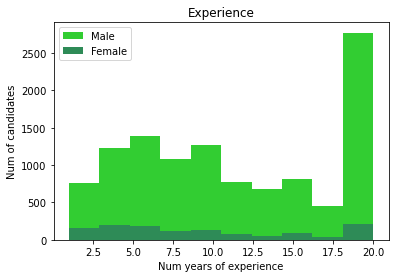

In [91]:
male = data[data["gender"]==1]
female = data[data["gender"]==0]
male_exp = male['experience'].to_numpy()
plt.hist(male_exp, color = "limegreen")
female_exp = female['experience'].to_numpy()
plt.hist(female_exp, color = "seagreen")
labels = ["Male", "Female"]
plt.legend(labels)
plt.title('Experience')
plt.xlabel('Num years of experience')
plt.ylabel('Num of candidates')

Text(0, 0.5, 'Num of candidates')

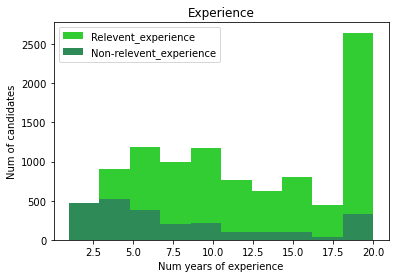

In [92]:
rexp = data[data["relevent_experience"]==1]
nrexp = data[data["relevent_experience"]==0]
male_exp = rexp['experience'].to_numpy()
plt.hist(male_exp, color = "limegreen")
female_exp = nrexp['experience'].to_numpy()
plt.hist(female_exp, color = "seagreen")
labels = ["Relevent_experience", "Non-relevent_experience"]
plt.legend(labels)
plt.title('Experience')
plt.xlabel('Num years of experience')
plt.ylabel('Num of candidates')

Text(0, 0.5, 'Num years of experience')

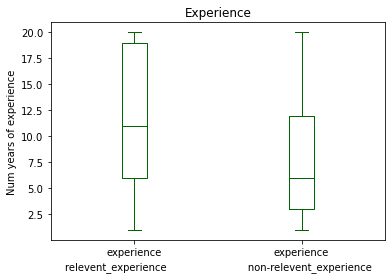

In [93]:
df2 = pd.concat([rexp['experience'], nrexp['experience']], axis=1)
df2.plot.box(color="darkgreen")
plt.title('Experience')
plt.xlabel('relevent_experience                          non-relevent_experience')
plt.ylabel('Num years of experience')

Text(0, 0.5, 'Num of candidates')

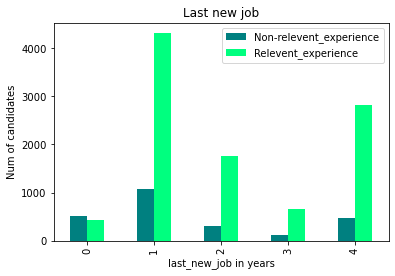

In [94]:
x=data.groupby(by=['relevent_experience', 'last_new_job'])['relevent_experience'].count().unstack('relevent_experience')
x.plot.bar(color = ['teal','springgreen'])
labels = ["Non-relevent_experience", "Relevent_experience"]
plt.legend(labels)
plt.title('Last new job')
plt.xlabel('last_new_job in years')
plt.ylabel('Num of candidates')